In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision
import torch.optim as optim
import pytorch_lightning as pl
import copy
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import torchmetrics
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
print(device)

cuda:0


In [3]:
classes=['Covid','No Covid']
num_classes=2
batch_size=4

In [4]:
# reshape all images to 64x64 and apply tensor transformation
dataset = torchvision.datasets.ImageFolder(root="./Full",transform=transforms.Compose([
                                                            transforms.ToTensor(),
                                                            transforms.Resize([227,227])
                                                            # transforms.Grayscale(num_output_channels=1)
                                                            ]))
# testset = torchvision.datasets.ImageFolder(root="./xray",train=False,transform=transforms.Compose([transforms.Resize([300,305]),transforms.ToTensor()]))
# testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

In [5]:
print(len(dataset))
trainset,testset=torch.utils.data.random_split(dataset,[round(0.8*len(dataset)),round(0.2*len(dataset))],generator=torch.Generator().manual_seed(42))
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False)
print(len(trainset)/batch_size,len(testset)/batch_size)

8088
1617.5 404.5


In [6]:
class RN(pl.LightningModule):
    def get_first_FC_Layer(self,x):
        x=self.feature_extractor(x).flatten(1)
        x=self.classifier[0](x)
        return x;
    def get_Representation_Net(self,x):
        x=self.feature_extractor(x).flatten(1)
        return  x;
    def __init__(self, learning_rate=0.001):
        super().__init__()
        self.learning_rate = learning_rate
        # init a pretrained vggnet
        backbone = models.resnet152(pretrained=True)
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        fc=[]
        fc.extend([nn.Linear(in_features=2048,out_features=512),
           nn.ReLU(),
           nn.Dropout(),
           nn.Linear(in_features=512,out_features=128),
           nn.ReLU(),
           nn.Dropout(),
           nn.Linear(in_features=128,out_features=1)
          ])
        self.classifier=nn.Sequential(*fc)
        for param in self.feature_extractor.parameters():
            param.requires_grad=False
#    def forward(self,x):
#         print(x.shape)
#        x=self.representation_network(x)
#         print(x.shape)
#        # flattening of the vector=> same dimension of first index(batch size) , everythign else is flattened(-1)
#        x=x.view(x.size(0),-1)
#         print(x.shape)
#        x=self.classification_network(x)
#         print(x.shape)
#        return x

In [7]:
net = RN()
net.load_state_dict(torch.load("RESNET152.pth").state_dict())

<All keys matched successfully>

In [8]:
def evaluation(dataloader,model):
    model.eval()
    with torch.no_grad():
        total,correct=0,0
        for data in dataloader:
            inputs,labels=data
            inputs,labels=inputs.to(device),labels.to(device)
            outputs=model(inputs)
    #         print(outputs)
    #         print(outputs,labels)
            m = nn.Sigmoid()
            outputs=m(outputs)
            pred=outputs>=0.5
            pred=pred.flatten()
            total+=labels.size(0)
            # labels=torch.add(labels,-1)
            # print(pred,labels)
    #         print(list(map(lambda a: classes[a],pred)),list(map(lambda a: classes[a],labels)))
            correct+=(pred==labels).sum().item()
    print(correct,total)
    model.train()
    return 100*correct/total

In [9]:
%%notify -m "Completed"

X_Train=np.empty((0,512))
Y_Train=np.empty((0,batch_size))
print(X_Train.shape)
for i,data in enumerate(trainloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    FCLayer=net.get_first_FC_Layer(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Train=np.append(X_Train,FCLayer,axis=0)
    Y_Train=np.append(Y_Train,labels.numpy())
print(X_Train.shape,Y_Train.shape)

(0, 512)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the bat

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


Done with the batch: 660
Done with the batch: 661
Done with the batch: 662
Done with the batch: 663
Done with the batch: 664
Done with the batch: 665
Done with the batch: 666
Done with the batch: 667
Done with the batch: 668
Done with the batch: 669
Done with the batch: 670
Done with the batch: 671
Done with the batch: 672
Done with the batch: 673
Done with the batch: 674
Done with the batch: 675
Done with the batch: 676
Done with the batch: 677
Done with the batch: 678
Done with the batch: 679
Done with the batch: 680
Done with the batch: 681
Done with the batch: 682
Done with the batch: 683
Done with the batch: 684
Done with the batch: 685
Done with the batch: 686
Done with the batch: 687
Done with the batch: 688
Done with the batch: 689
Done with the batch: 690
Done with the batch: 691
Done with the batch: 692
Done with the batch: 693
Done with the batch: 694
Done with the batch: 695
Done with the batch: 696
Done with the batch: 697
Done with the batch: 698
Done with the batch: 699


Done with the batch: 988
Done with the batch: 989
Done with the batch: 990
Done with the batch: 991
Done with the batch: 992
Done with the batch: 993
Done with the batch: 994
Done with the batch: 995
Done with the batch: 996
Done with the batch: 997
Done with the batch: 998
Done with the batch: 999
Done with the batch: 1000
Done with the batch: 1001
Done with the batch: 1002
Done with the batch: 1003
Done with the batch: 1004
Done with the batch: 1005
Done with the batch: 1006
Done with the batch: 1007
Done with the batch: 1008
Done with the batch: 1009
Done with the batch: 1010
Done with the batch: 1011
Done with the batch: 1012
Done with the batch: 1013
Done with the batch: 1014
Done with the batch: 1015
Done with the batch: 1016
Done with the batch: 1017
Done with the batch: 1018
Done with the batch: 1019
Done with the batch: 1020
Done with the batch: 1021
Done with the batch: 1022
Done with the batch: 1023
Done with the batch: 1024
Done with the batch: 1025
Done with the batch: 102

Done with the batch: 1304
Done with the batch: 1305
Done with the batch: 1306
Done with the batch: 1307
Done with the batch: 1308
Done with the batch: 1309
Done with the batch: 1310
Done with the batch: 1311
Done with the batch: 1312
Done with the batch: 1313
Done with the batch: 1314
Done with the batch: 1315
Done with the batch: 1316
Done with the batch: 1317
Done with the batch: 1318
Done with the batch: 1319
Done with the batch: 1320
Done with the batch: 1321
Done with the batch: 1322
Done with the batch: 1323
Done with the batch: 1324
Done with the batch: 1325
Done with the batch: 1326
Done with the batch: 1327
Done with the batch: 1328
Done with the batch: 1329
Done with the batch: 1330
Done with the batch: 1331
Done with the batch: 1332
Done with the batch: 1333
Done with the batch: 1334
Done with the batch: 1335
Done with the batch: 1336
Done with the batch: 1337
Done with the batch: 1338
Done with the batch: 1339
Done with the batch: 1340
Done with the batch: 1341
Done with th

<IPython.core.display.Javascript object>

In [10]:
%%notify -m "Completed"
X_Test=np.empty((0,512))
Y_Test=np.empty((0,batch_size))
print(X_Test.shape)
for i,data in enumerate(testloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    FCLayer=net.get_first_FC_Layer(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Test=np.append(X_Test,FCLayer,axis=0)
    Y_Test=np.append(Y_Test,labels.numpy())
print(X_Test.shape,Y_Test.shape)

(0, 512)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the bat

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


<IPython.core.display.Javascript object>

In [11]:
%%notify -m "Completed"
X_Train_FeatureMap=np.empty((0,2048))
Y_Train_FeatureMap=np.empty((0,batch_size))
print(X_Train_FeatureMap.shape)
for i,data in enumerate(trainloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    featureMap=net.get_Representation_Net(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Train_FeatureMap=np.append(X_Train_FeatureMap,featureMap,axis=0)
    Y_Train_FeatureMap=np.append(Y_Train_FeatureMap,labels.numpy())
print(X_Train_FeatureMap.shape,Y_Train_FeatureMap.shape)

(0, 2048)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the ba

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


Done with the batch: 660
Done with the batch: 661
Done with the batch: 662
Done with the batch: 663
Done with the batch: 664
Done with the batch: 665
Done with the batch: 666
Done with the batch: 667
Done with the batch: 668
Done with the batch: 669
Done with the batch: 670
Done with the batch: 671
Done with the batch: 672
Done with the batch: 673
Done with the batch: 674
Done with the batch: 675
Done with the batch: 676
Done with the batch: 677
Done with the batch: 678
Done with the batch: 679
Done with the batch: 680
Done with the batch: 681
Done with the batch: 682
Done with the batch: 683
Done with the batch: 684
Done with the batch: 685
Done with the batch: 686
Done with the batch: 687
Done with the batch: 688
Done with the batch: 689
Done with the batch: 690
Done with the batch: 691
Done with the batch: 692
Done with the batch: 693
Done with the batch: 694
Done with the batch: 695
Done with the batch: 696
Done with the batch: 697
Done with the batch: 698
Done with the batch: 699


Done with the batch: 988
Done with the batch: 989
Done with the batch: 990
Done with the batch: 991
Done with the batch: 992
Done with the batch: 993
Done with the batch: 994
Done with the batch: 995
Done with the batch: 996
Done with the batch: 997
Done with the batch: 998
Done with the batch: 999
Done with the batch: 1000
Done with the batch: 1001
Done with the batch: 1002
Done with the batch: 1003
Done with the batch: 1004
Done with the batch: 1005
Done with the batch: 1006
Done with the batch: 1007
Done with the batch: 1008
Done with the batch: 1009
Done with the batch: 1010
Done with the batch: 1011
Done with the batch: 1012
Done with the batch: 1013
Done with the batch: 1014
Done with the batch: 1015
Done with the batch: 1016
Done with the batch: 1017
Done with the batch: 1018
Done with the batch: 1019
Done with the batch: 1020
Done with the batch: 1021
Done with the batch: 1022
Done with the batch: 1023
Done with the batch: 1024
Done with the batch: 1025
Done with the batch: 102

Done with the batch: 1304
Done with the batch: 1305
Done with the batch: 1306
Done with the batch: 1307
Done with the batch: 1308
Done with the batch: 1309
Done with the batch: 1310
Done with the batch: 1311
Done with the batch: 1312
Done with the batch: 1313
Done with the batch: 1314
Done with the batch: 1315
Done with the batch: 1316
Done with the batch: 1317
Done with the batch: 1318
Done with the batch: 1319
Done with the batch: 1320
Done with the batch: 1321
Done with the batch: 1322
Done with the batch: 1323
Done with the batch: 1324
Done with the batch: 1325
Done with the batch: 1326
Done with the batch: 1327
Done with the batch: 1328
Done with the batch: 1329
Done with the batch: 1330
Done with the batch: 1331
Done with the batch: 1332
Done with the batch: 1333
Done with the batch: 1334
Done with the batch: 1335
Done with the batch: 1336
Done with the batch: 1337
Done with the batch: 1338
Done with the batch: 1339
Done with the batch: 1340
Done with the batch: 1341
Done with th

<IPython.core.display.Javascript object>

In [12]:
%%notify -m "Completed"
X_Test_FeatureMap=np.empty((0,2048))
Y_Test_FeatureMap=np.empty((0,batch_size))
print(X_Test_FeatureMap.shape)
for i,data in enumerate(testloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    featuremap=net.get_Representation_Net(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Test_FeatureMap=np.append(X_Test_FeatureMap,featuremap,axis=0)
    Y_Test_FeatureMap=np.append(Y_Test_FeatureMap,labels.numpy())
print(X_Test_FeatureMap.shape,Y_Test_FeatureMap.shape)

(0, 2048)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the ba

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


<IPython.core.display.Javascript object>

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold

In [14]:
tuned_parameters = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-2,0.1,1,10],
                     'C': [0.001,0.1,1, 10, 100],
}
# tuned_parameters = {'kernel': ['rbf'], 'gamma': [1e-3],
#                      'C': [0.001],
#                    }
clf = GridSearchCV(
        SVC(), tuned_parameters, scoring= 'accuracy',verbose=10
    )
clf.fit(X_Train, Y_Train.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 1/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.863 total time=  13.2s
[CV 2/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 2/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.857 total time=  13.0s
[CV 3/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 3/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.850 total time=  13.0s
[CV 4/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 4/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.853 total time=  13.0s
[CV 5/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 5/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.856 total time=  13.2s
[CV 1/5; 2/25] START C=0.001, gamma=0.01, kernel=rbf............................
[CV 1/5; 2/25] END C=0.001,

[CV 1/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.887 total time=   4.2s
[CV 2/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 2/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.882 total time=   4.1s
[CV 3/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 3/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.882 total time=   4.2s
[CV 4/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 4/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.887 total time=   4.2s
[CV 5/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 5/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.881 total time=   4.2s
[CV 1/5; 12/25] START C=1, gamma=0.01, kernel=rbf...............................
[CV 1/5; 12/25] END C=1, gamma=0.01, kernel=rbf;, score=0.891 total time=   6.1s
[CV 2/5; 12/25] START C=1, gamma=0.01, kernel=rbf...............................
[CV 2/5; 12/25] END C=1

[CV 2/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.900 total time=   6.0s
[CV 3/5; 21/25] START C=100, gamma=0.001, kernel=rbf............................
[CV 3/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.917 total time=   6.2s
[CV 4/5; 21/25] START C=100, gamma=0.001, kernel=rbf............................
[CV 4/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.900 total time=   5.9s
[CV 5/5; 21/25] START C=100, gamma=0.001, kernel=rbf............................
[CV 5/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.900 total time=   5.8s
[CV 1/5; 22/25] START C=100, gamma=0.01, kernel=rbf.............................
[CV 1/5; 22/25] END C=100, gamma=0.01, kernel=rbf;, score=0.896 total time=   8.9s
[CV 2/5; 22/25] START C=100, gamma=0.01, kernel=rbf.............................
[CV 2/5; 22/25] END C=100, gamma=0.01, kernel=rbf;, score=0.890 total time=   6.8s
[CV 3/5; 22/25] START C=100, gamma=0.01, kernel=rbf.............................
[CV 3/5; 22/

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=10)

In [14]:
def k_fold_cv_svm(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        clf=SVC(C=100,kernel='rbf',gamma=0.001)
        clf.fit(X_train,y_train.ravel())
        y_pred = clf.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del clf
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return clf

In [15]:
clf=k_fold_cv_svm(X_Train,Y_Train.ravel())
y_pred=clf.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test,y_pred))
print("Precision: ",precision_score(Y_Test,y_pred))
print("Recall: ",recall_score(Y_Test,y_pred))
print("F1-Score: ",f1_score(Y_Test,y_pred))
print("AUC: ",roc_auc_score(Y_Test,y_pred))

FOLD 0
--------------------------------
Accuracy: 90.03091190108191
FOLD 1
--------------------------------
Accuracy: 91.34466769706336
FOLD 2
--------------------------------
Accuracy: 90.1854714064915
FOLD 3
--------------------------------
Accuracy: 90.1854714064915
FOLD 4
--------------------------------
Accuracy: 88.87171561051005
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 90.03091190108191 %
Fold 1: 91.34466769706336 %
Fold 2: 90.1854714064915 %
Fold 3: 90.1854714064915 %
Fold 4: 88.87171561051005 %
Average: 90.12364760432766 %
Accuracy:  0.9023485784919654
Precision:  0.9104477611940298
Recall:  0.8948655256723717
F1-Score:  0.902589395807645
AUC:  0.9024327628361859


In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
def k_fold_cv_dtree(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        decision_tree = DecisionTreeClassifier(random_state=102)
        decision_tree = decision_tree.fit(X_train, y_train.ravel())
        y_pred = decision_tree.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del decision_tree
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return decision_tree

In [19]:
dtree=k_fold_cv_dtree(X_Train,Y_Train.ravel())
y_pred=dtree.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test,y_pred))
print("Precision: ",precision_score(Y_Test,y_pred))
print("Recall: ",recall_score(Y_Test,y_pred))
print("F1-Score: ",f1_score(Y_Test,y_pred))
print("AUC: ",roc_auc_score(Y_Test,y_pred))

FOLD 0
--------------------------------
Accuracy: 80.91190108191654
FOLD 1
--------------------------------
Accuracy: 80.60278207109737
FOLD 2
--------------------------------
Accuracy: 82.9984544049459
FOLD 3
--------------------------------
Accuracy: 80.75734157650696
FOLD 4
--------------------------------
Accuracy: 81.14374034003092
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 80.91190108191654 %
Fold 1: 80.60278207109737 %
Fold 2: 82.9984544049459 %
Fold 3: 80.75734157650696 %
Fold 4: 81.14374034003092 %
Average: 81.28284389489954 %
Accuracy:  0.8084054388133498
Precision:  0.815136476426799
Recall:  0.8031784841075794
F1-Score:  0.8091133004926108
AUC:  0.8084642420537896


In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
def k_fold_cv_rforest(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        random_forest = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=102)
        random_forest = random_forest.fit(X_train, y_train.ravel())
        y_pred = random_forest.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del random_forest
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return random_forest

In [22]:
random_forest=k_fold_cv_rforest(X_Train,Y_Train.ravel())
y_pred=random_forest.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test,y_pred))
print("Precision: ",precision_score(Y_Test,y_pred))
print("Recall: ",recall_score(Y_Test,y_pred))
print("F1-Score: ",f1_score(Y_Test,y_pred))
print("AUC: ",roc_auc_score(Y_Test,y_pred))

FOLD 0
--------------------------------
Accuracy: 86.01236476043277
FOLD 1
--------------------------------
Accuracy: 87.24884080370943
FOLD 2
--------------------------------
Accuracy: 87.24884080370943
FOLD 3
--------------------------------
Accuracy: 88.4853168469861
FOLD 4
--------------------------------
Accuracy: 89.3353941267388
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 86.01236476043277 %
Fold 1: 87.24884080370943 %
Fold 2: 87.24884080370943 %
Fold 3: 88.4853168469861 %
Fold 4: 89.3353941267388 %
Average: 87.66615146831529 %
Accuracy:  0.880716934487021
Precision:  0.9053177691309987
Recall:  0.8533007334963325
F1-Score:  0.8785399622404028
AUC:  0.8810253667481662


In [23]:
import xgboost as xgb


In [24]:
def k_fold_cv_xgb(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        eval_set = [(X_train, y_train.ravel()), (X_test, y_test)]
        xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=102,use_label_encoder=False)
        xg_cl.fit(X_train,y_train.ravel())
        y_pred = xg_cl.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del xg_cl
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return xg_cl

In [25]:
xg=k_fold_cv_xgb(X_Train,Y_Train.ravel())
y_pred=xg.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test,y_pred))
print("Precision: ",precision_score(Y_Test,y_pred))
print("Recall: ",recall_score(Y_Test,y_pred))
print("F1-Score: ",f1_score(Y_Test,y_pred))
print("AUC: ",roc_auc_score(Y_Test,y_pred))

FOLD 0
--------------------------------
[22:12:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 88.87171561051005
FOLD 1
--------------------------------
[22:13:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 88.25347758887172
FOLD 2
--------------------------------
[22:13:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was

In [26]:
from sklearn.neural_network import MLPClassifier

In [27]:
def k_fold_cv_mlp(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        clf = MLPClassifier(random_state=102, max_iter=3000, verbose=True).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del clf
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return clf

In [28]:
clf=k_fold_cv_mlp(X_Train,Y_Train.ravel())
y_pred=clf.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test,y_pred))
print("Precision: ",precision_score(Y_Test,y_pred))
print("Recall: ",recall_score(Y_Test,y_pred))
print("F1-Score: ",f1_score(Y_Test,y_pred))
print("AUC: ",roc_auc_score(Y_Test,y_pred))

FOLD 0
--------------------------------
Iteration 1, loss = 1.11725855
Iteration 2, loss = 0.40724097
Iteration 3, loss = 0.37346770
Iteration 4, loss = 0.38956734
Iteration 5, loss = 0.40234297
Iteration 6, loss = 0.39633479
Iteration 7, loss = 0.39175410
Iteration 8, loss = 0.41922518
Iteration 9, loss = 0.39420172
Iteration 10, loss = 0.42467072
Iteration 11, loss = 0.38911715
Iteration 12, loss = 0.36059605
Iteration 13, loss = 0.36688719
Iteration 14, loss = 0.40571587
Iteration 15, loss = 0.38068076
Iteration 16, loss = 0.40692179
Iteration 17, loss = 0.35558509
Iteration 18, loss = 0.37875057
Iteration 19, loss = 0.47249328
Iteration 20, loss = 0.37169509
Iteration 21, loss = 0.35153450
Iteration 22, loss = 0.35434948
Iteration 23, loss = 0.37168518
Iteration 24, loss = 0.36763377
Iteration 25, loss = 0.39716516
Iteration 26, loss = 0.35354331
Iteration 27, loss = 0.35456862
Iteration 28, loss = 0.37198735
Iteration 29, loss = 0.38311290
Iteration 30, loss = 0.36357087
Iteration

In [29]:
from sklearn.decomposition import KernelPCA

Text(0, 0.5, 'cumulative explained variance')

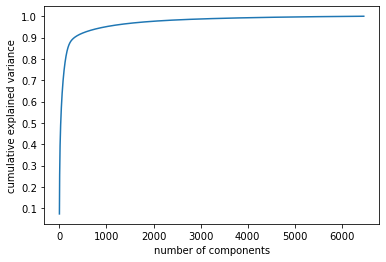

In [30]:
kpca = KernelPCA(kernel = 'rbf')
kpca_transform = kpca.fit_transform(X_Train_FeatureMap)
explained_variance = np.var(kpca_transform, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [30]:
kpca = KernelPCA(kernel = 'rbf',n_components=5000)
X_Train_Transformed_FeatureMap = kpca.fit_transform(X_Train_FeatureMap)
print(X_Train_Transformed_FeatureMap.shape)

(6470, 5000)


In [31]:
X_Test_Transformed_FeatureMap = kpca.transform(X_Test_FeatureMap)

print(X_Test_FeatureMap.shape,X_Test_Transformed_FeatureMap.shape)

(1618, 2048) (1618, 5000)


In [33]:
# %% notify -m "GridCV"
tuned_parameters = {'kernel': ['rbf'], 'gamma': [10,100],
                     'C': [10],
}
clf = GridSearchCV(
        SVC(), tuned_parameters, scoring= 'accuracy',verbose=10
    )
clf.fit(X_Train_Transformed_FeatureMap, Y_Train_FeatureMap.ravel())

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START C=10, gamma=10, kernel=rbf..................................
[CV 1/5; 1/2] END ...C=10, gamma=10, kernel=rbf;, score=0.932 total time= 1.7min
[CV 2/5; 1/2] START C=10, gamma=10, kernel=rbf..................................
[CV 2/5; 1/2] END ...C=10, gamma=10, kernel=rbf;, score=0.920 total time= 1.8min
[CV 3/5; 1/2] START C=10, gamma=10, kernel=rbf..................................
[CV 3/5; 1/2] END ...C=10, gamma=10, kernel=rbf;, score=0.932 total time= 1.7min
[CV 4/5; 1/2] START C=10, gamma=10, kernel=rbf..................................
[CV 4/5; 1/2] END ...C=10, gamma=10, kernel=rbf;, score=0.937 total time= 1.8min
[CV 5/5; 1/2] START C=10, gamma=10, kernel=rbf..................................
[CV 5/5; 1/2] END ...C=10, gamma=10, kernel=rbf;, score=0.921 total time= 1.6min
[CV 1/5; 2/2] START C=10, gamma=100, kernel=rbf.................................
[CV 1/5; 2/2] END ..C=10, gamma=100, kernel=rbf;,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [10], 'gamma': [10, 100], 'kernel': ['rbf']},
             scoring='accuracy', verbose=10)

In [32]:
clf=k_fold_cv_svm(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=clf.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 82.22565687789799
FOLD 1
--------------------------------
Accuracy: 83.23029366306028
FOLD 2
--------------------------------
Accuracy: 84.15765069551777
FOLD 3
--------------------------------
Accuracy: 84.54404945904173
FOLD 4
--------------------------------
Accuracy: 86.5533230293663
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 82.22565687789799 %
Fold 1: 83.23029366306028 %
Fold 2: 84.15765069551777 %
Fold 3: 84.54404945904173 %
Fold 4: 86.5533230293663 %
Average: 84.14219474497682 %
Accuracy:  0.8473423980222496
Precision:  0.8609355246523388
Recall:  0.8325183374083129
F1-Score:  0.8464885021752642
AUC:  0.8475091687041566


In [33]:
dtree=k_fold_cv_dtree(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=dtree.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 75.34775888717155
FOLD 1
--------------------------------
Accuracy: 76.12055641421948
FOLD 2
--------------------------------
Accuracy: 78.74806800618238
FOLD 3
--------------------------------
Accuracy: 76.27511591962906
FOLD 4
--------------------------------
Accuracy: 75.9659969088099
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 75.34775888717155 %
Fold 1: 76.12055641421948 %
Fold 2: 78.74806800618238 %
Fold 3: 76.27511591962906 %
Fold 4: 75.9659969088099 %
Average: 76.49149922720248 %
Accuracy:  0.7855377008652658
Precision:  0.7969735182849937
Recall:  0.7726161369193154
F1-Score:  0.7846058348851644
AUC:  0.7856830684596576


In [34]:
xg=k_fold_cv_xgb(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=xg.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
[22:31:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 87.71251931993818
FOLD 1
--------------------------------
[22:33:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 88.3307573415765
FOLD 2
--------------------------------
[22:36:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was 

In [35]:
clf=k_fold_cv_mlp(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=clf.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Iteration 1, loss = 0.69066447
Iteration 2, loss = 0.66757498
Iteration 3, loss = 0.63610941
Iteration 4, loss = 0.59500998
Iteration 5, loss = 0.54713854
Iteration 6, loss = 0.49709817
Iteration 7, loss = 0.44887012
Iteration 8, loss = 0.40515397
Iteration 9, loss = 0.36614235
Iteration 10, loss = 0.33237804
Iteration 11, loss = 0.30342388
Iteration 12, loss = 0.27854315
Iteration 13, loss = 0.25741828
Iteration 14, loss = 0.23878644
Iteration 15, loss = 0.22231126
Iteration 16, loss = 0.20793013
Iteration 17, loss = 0.19506311
Iteration 18, loss = 0.18357825
Iteration 19, loss = 0.17273258
Iteration 20, loss = 0.16276574
Iteration 21, loss = 0.15361124
Iteration 22, loss = 0.14503565
Iteration 23, loss = 0.13719901
Iteration 24, loss = 0.12947842
Iteration 25, loss = 0.12260290
Iteration 26, loss = 0.11602441
Iteration 27, loss = 0.10982266
Iteration 28, loss = 0.10438717
Iteration 29, loss = 0.09827244
Iteration 30, loss = 0.09309764
Iteration

Iteration 12, loss = 0.27324411
Iteration 13, loss = 0.25192661
Iteration 14, loss = 0.23353602
Iteration 15, loss = 0.21723703
Iteration 16, loss = 0.20280531
Iteration 17, loss = 0.18975869
Iteration 18, loss = 0.17809358
Iteration 19, loss = 0.16745331
Iteration 20, loss = 0.15761810
Iteration 21, loss = 0.14869020
Iteration 22, loss = 0.14022255
Iteration 23, loss = 0.13240652
Iteration 24, loss = 0.12499957
Iteration 25, loss = 0.11812178
Iteration 26, loss = 0.11161806
Iteration 27, loss = 0.10569365
Iteration 28, loss = 0.09980011
Iteration 29, loss = 0.09449810
Iteration 30, loss = 0.08939153
Iteration 31, loss = 0.08472472
Iteration 32, loss = 0.08016100
Iteration 33, loss = 0.07605198
Iteration 34, loss = 0.07201686
Iteration 35, loss = 0.06839355
Iteration 36, loss = 0.06478918
Iteration 37, loss = 0.06159861
Iteration 38, loss = 0.05872273
Iteration 39, loss = 0.05571616
Iteration 40, loss = 0.05304347
Iteration 41, loss = 0.05051995
Iteration 42, loss = 0.04819020
Iteratio

Iteration 27, loss = 0.10663251
Iteration 28, loss = 0.10108571
Iteration 29, loss = 0.09577464
Iteration 30, loss = 0.09069007
Iteration 31, loss = 0.08581056
Iteration 32, loss = 0.08144757
Iteration 33, loss = 0.07766708
Iteration 34, loss = 0.07355042
Iteration 35, loss = 0.06970008
Iteration 36, loss = 0.06617720
Iteration 37, loss = 0.06300594
Iteration 38, loss = 0.05984137
Iteration 39, loss = 0.05703124
Iteration 40, loss = 0.05421051
Iteration 41, loss = 0.05167256
Iteration 42, loss = 0.04934097
Iteration 43, loss = 0.04712807
Iteration 44, loss = 0.04505028
Iteration 45, loss = 0.04313967
Iteration 46, loss = 0.04121560
Iteration 47, loss = 0.03963112
Iteration 48, loss = 0.03798457
Iteration 49, loss = 0.03642759
Iteration 50, loss = 0.03501327
Iteration 51, loss = 0.03370854
Iteration 52, loss = 0.03247359
Iteration 53, loss = 0.03130716
Iteration 54, loss = 0.03021933
Iteration 55, loss = 0.02920775
Iteration 56, loss = 0.02824551
Iteration 57, loss = 0.02736957
Iteratio

In [36]:
random_forest=k_fold_cv_rforest(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=random_forest.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 77.04791344667697
FOLD 1
--------------------------------
Accuracy: 73.64760432766614
FOLD 2
--------------------------------
Accuracy: 75.19319938176197
FOLD 3
--------------------------------
Accuracy: 75.19319938176197
FOLD 4
--------------------------------
Accuracy: 74.57496136012365
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 77.04791344667697 %
Fold 1: 73.64760432766614 %
Fold 2: 75.19319938176197 %
Fold 3: 75.19319938176197 %
Fold 4: 74.57496136012365 %
Average: 75.13137557959814 %
Accuracy:  0.7775030902348579
Precision:  0.7510964912280702
Recall:  0.8374083129584352
F1-Score:  0.7919075144508672
AUC:  0.7768291564792176
